# Task: Classifying Galaxy10 Dataset with pretrained ResNet

## IMPORTANT NOTE!!!! This code is split into parts that explain the reasoning behind each snippet, but it is meant to run as a single .py file as a remote job on a computing cluster. The reason it is written this way is because Google Colab and Kaggle provide substandard GPUs and have inbuilt mechanisms that require you to be active on the tab lest the session get deactivated. For peace of mind, it is easier to execute this as a single Python script.

The task is fairly straightforward. First, we import the libraries we require.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
import optuna
import h5py
import matplotlib.pyplot as plt
import numpy as np

Then, we set a manual seed as required by the task.

In [ ]:
torch.manual_seed(10)

Then, we define some filler functions and helper functions. Note that since we need to use PyTorch, we define a custom class for convenience. Also, to leverage the GPU, we set the PyTorch device to CUDA if available. 

In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

# Load the Galaxy10 dataset from an h5 file
def load_galaxy10_data(file_path):
    with h5py.File(file_path, 'r') as f:
        images = f['images'][:]
        labels = f['ans'][:]
    return images, labels

# Define a custom dataset class
class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset and split it into train, validation, and test sets
images, labels = load_galaxy10_data('Galaxy10.h5')

Now it's time for data augmentation and transforming.

In [ ]:
# Define data augmentation and transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Replace with actual mean and std
])
X_train, X_tmp, y_train, y_tmp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

train_dataset = Galaxy10Dataset(X_train, y_train, transform=transform)
val_dataset = Galaxy10Dataset(X_val, y_val, transform=transform)
test_dataset = Galaxy10Dataset(X_test, y_test, transform=transform)

There are a few things to note here. First, since ResNet is trained on images of size 224x224, it is convenient to reshape the images to 224x224. In my testing, there was no particular difference on passing the default image size (69x69) to the model directly. However, to avoid the possibility of image padding, I ended up resizing images anyway. The other functions, such as random flipping, are added to generalize the dataset. 

The last important thing is the mean and standard deviation done for normalization. Originally, I calculated the mean and standard deviation of the dataset directly. However it turned out that I was getting horrible accuracies. Therefore, I ended up doing with the ImageNet mean and standard deviation. It gives somewhat better performance, but there should be some smart way to find the best value here; I was unable to do so.

Otherwise, we just split the datasets into a 70:15:15 ratio as required.

To optimize, I chose the Optuna library because I couldn't figure out a smart way to optimize by hand without adding endless for loops. Using a library that does optimization seemed like the most straightforward approach. The code for Optuna is below.

In [ ]:
# Define an Optuna objective function to optimize hyperparameters
def objective(trial):
    print(f"Trial {trial.number}: Hyperparameter tuning in progress...")
    # Hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])  # Adjust batch size options as needed

    # Create data loaders with the chosen batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

    # Initialize the model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # 10 output classes for Galaxy10
    model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    num_epochs = 10
    best_accuracy = 0.0

    # Log file for training output
    log_file = open('training_log.txt', 'w')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_outputs = model(inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_predictions.extend(val_preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_targets, val_predictions)
        log_message = f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
        print(log_message)
        log_file.write(log_message + '\n')

        # Save the model if it's the best so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    log_file.close()
    return -best_accuracy  # Optuna minimizes the objective, so we negate accuracy

Optuna minimizes the objective function, so the final value has to be negated to get the best accuracy. 

We optimize three hyperparameters - the learning rate, the weight decay, and the batch size. The trial.suggest_float() method provides an improved guess of the parameters for the next trial. Plus, to make things easier, I went with a logarithmic scale so I could have somewhat uniform values.

The method is simple - first, initialize the model and use pretrained weights. The loss we use is the cross-entropy loss as we are doing a classification task. I used the Adam optimizer instead of SGD because Adam seemed to give better results in my initial tests, but upon further testing there wasn't really a big difference in Adam and SGD, so either of them would be fine.

I set 10 epochs for the final training loop, as each epoch took anywhere from 1-3 minutes. 50 trials x 10 epochs per trial x 1-3 minutes per epoch and we're looking at around 1000 minutes, or roughly 16 hours to optimize the model. In practice, this time turns out to be significantly less (about 4.5 hours) but it varies, and due to the limited time I had to do this task I ended up using this value. A more complete treatment would possibly perform the task for more epochs.

For my convenience, I added a progress bar with tqdm (although this does slow down the overall execution, as switching to a print statement diverts resources rather unfairly) and did a straightforward loss checker. The logic behind the code is that a lower loss and higher accuracy gives a better model, so each subsequently better model is saved as the best model until that point.

In [ ]:
# Optuna hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # You can adjust the number of trials as needed

# Get the best hyperparameters
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']
best_batch_size = best_params['batch_size']

print(f'Best Learning Rate: {best_learning_rate:.6f}')
print(f'Best Weight Decay: {best_weight_decay:.6f}')
print(f'Best Batch Size: {best_batch_size}')

# Train the model with the best hyperparameters
best_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 10)
best_model.to(device)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

Now, we create an Optuna study (an object that does all the testing for us) and start optimizing. Once we obtained the best hyperparameters, I printed everything for my sake, and then proceeded to train the best model with the best hyperparameters.

In [ ]:
# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, num_workers=4)

num_epochs = 20
best_accuracy = 0.0

# Log file for training output
log_file = open('training_log.txt', 'a')

for epoch in range(num_epochs):
    print('In the best model training loop right now')
    best_model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100):
        inputs, labels = inputs.to(device), labels.to(device)
        best_optimizer.zero_grad()
        outputs = best_model(inputs)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_loss = running_loss / len(train_loader)

    # Validation
    best_model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = best_model(inputs)
            _, val_preds = torch.max(val_outputs, 1)
            val_predictions.extend(val_preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_targets, val_predictions)
    log_message = f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
    print(log_message)
    log_file.write(log_message + '\n')

    # Save the model if it's the best so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(best_model.state_dict(), 'best_model.pth')

log_file.close()

This is just carbon-copied code. The best model is trained and saved.

In [ ]:
# Load the best model
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Testing
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        test_outputs = best_model(inputs)
        _, test_preds = torch.max(test_outputs, 1)
        test_predictions.extend(test_preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Classification report
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
classification_rep = classification_report(test_targets, test_predictions, target_names=class_names)

# Save outputs to files
with open('output.txt', 'w') as output_file:
    output_file.write("Test Accuracy: {:.4f}\n".format(test_accuracy))
    output_file.write("\nClassification Report:\n")
    output_file.write(classification_rep)


Next, I load the best model and test it. I then generate a classification report automatically with the imported libraries and save all the output to a file. I will show the classification report momentarily. However, there are two tasks left: plotting weight norms and plotting feature maps.

In [ ]:
# Plot weights norm and save to a file
def plot_weights_norm(model):
    weight_norms = []

    for name, param in model.named_parameters():
        if 'weight' in name:
            weight_norm = param.norm().item()
            weight_norms.append(weight_norm)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(weight_norms)), weight_norms, marker='o')
    plt.xlabel('Layer')
    plt.ylabel('Weight Norm')
    plt.title('Weight Norms for Each Layer')
    plt.grid(True)
    plt.savefig('weight_norms.png')  # Save the plot as an image

# Call the function to plot weight norms
plot_weights_norm(best_model)

Plotting weight norms is fairly straightforward. Get the weight parameters from the model, and plot them. 

Plotting the feature maps is significantly more involved. First, I choose a random image to plot the feature map on.

In [ ]:
# Choose an image from the test dataset
fixed_image, _ = test_dataset[0]
fixed_image = fixed_image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

Since the dataset is shuffled, this will be random, but it really doesn't matter. Now I have to get the feature maps from the model. I do this by using 'hooks'. This was something new I had to learn, but I know it now.

In [ ]:
# Get feature maps from the model
def get_intermediate_feature_maps(model, image):
    activation = {}

    def hook(name):
        def hook_fn(module, input, output):
            activation[name] = output
        return hook_fn

    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, nn.Conv2d):
            hook_fn = hook(name)
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(image)

    for hook in hooks:
        hook.remove()

    return activation

feature_maps = get_intermediate_feature_maps(best_model, fixed_image)

This is straightforward. I just add all 2-D convolution layers to a feature map.

In [ ]:
# Visualize the feature maps (you can choose a specific layer)
layer_name = 'conv1'  # Replace with the layer name you want to visualize
feature_map = feature_maps[layer_name].cpu().squeeze(0)  # Remove batch dimension and move to CPU

# Visualize the feature maps in a grid
def visualize_feature_maps_grid(feature_map):
    num_feature_maps = feature_map.size(0)
    rows = int(np.sqrt(num_feature_maps))
    cols = int(np.ceil(num_feature_maps / rows))
    
    plt.figure(figsize=(12, 12))
    for i in range(num_feature_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_map[i], cmap='viridis')  # Watch colormap
        plt.title(f'Feature Map {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('feature_maps_grid.png')  # Save the grid of feature maps as an image

# Call the function to visualize feature maps in a grid
visualize_feature_maps_grid(feature_map)

Then, I visualize them. Note that there's two things here - getting the feature maps to a grid is significantly harder than it looks, as you have to define a custom function for that. By default a figure with all the feature maps in a row is generated and it is impossible to understand

The second thing is that the layer I chose was the conv1 layer. Frankly, I could have chosen any other layer, but this was at the top of the list when I printed all the layer names. I don't think this generates any useful information, but I am new to the field of computer vision and therefore I didn't choose any other layer to create a feature map. I think choosing the first layer might be more important, but I could be and probably am wrong. Maybe the last layer is the one I need?

In [ ]:
print("Outputs saved to 'output.txt', 'weight_norms.png', 'feature_maps.png', and 'feature_maps_grid.png'")
print("Reached the end")

This just tells me that my script worked and went to the end. Actually, I realized that 'feature_maps.png' is not in fact generated since I removed that part of the code out a long time ago, but it is interesting to see what would happen if I didn't plot them in a grid. So I left this text in.

# Results

Now we will see the results. 

First, let me post the output of the classification report:
Test Accuracy: 0.3455

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.05      0.00      0.01       538
     Class 1       0.43      0.96      0.60      1087
     Class 2       0.10      0.09      0.09       900
     Class 3       0.00      0.00      0.00        53
     Class 4       0.00      0.00      0.00       243
     Class 5       0.00      0.00      0.00         3
     Class 6       0.00      0.00      0.00        73
     Class 7       0.00      0.00      0.00       159
     Class 8       0.00      0.00      0.00       130
     Class 9       0.00      0.00      0.00        82

    accuracy                           0.35      3268
   macro avg       0.06      0.11      0.07      3268
weighted avg       0.18      0.35      0.23      3268

It turns out that I am getting horrible accuracy, but that could be due to a number of reasons. Personally, I think the problem lies somewhere in the image transforms, but I could be wrong. However I am not doctoring my results as I think the purpose of this task is just to show that I have understood the concept, so I am leaving these horrible results in. I want to note that I got better accuracy during one of my initial runs on Google Colab, but I am unable to recreate it as it was several hundred runs ago and many things have changed since then.

Next, to convert the classification report, I simply run this code snippet:

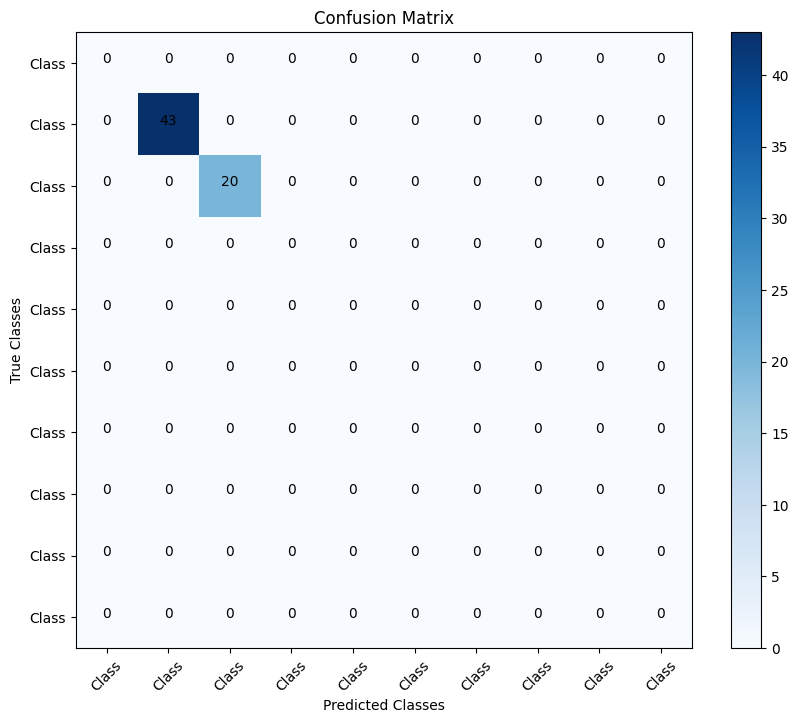

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Read the contents of the 'output.txt' file
with open('output.txt', 'r') as file:
    lines = file.readlines()

# Find the start of the classification report
start_idx = None
for i, line in enumerate(lines):
    if line.strip() == 'Classification Report:':
        start_idx = i + 3  # Start from the line after the header
        break

if start_idx is not None:
    # Initialize empty lists to store class names, precision, and recall
    class_names = []
    precision = []
    recall = []

    # Extract the confusion matrix data line by line
    for i in range(start_idx, start_idx + 10):
        line = lines[i].split()
        if len(line) >= 5:
            class_names.append(line[0])
            precision.append(float(line[1]))
            recall.append(float(line[2]))

    # Create a confusion matrix manually
    num_classes = len(class_names)
    confusion_matrix_data = np.zeros((num_classes, num_classes), dtype=int)

    # Assign precision and recall values to the diagonal
    for i in range(num_classes):
        confusion_matrix_data[i, i] = int(precision[i] * recall[i] * 100)  # Multiply by 100 for better visualization

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix_data, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, confusion_matrix_data[i, j], horizontalalignment="center", color="black")

    plt.ylabel('True Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
else:
    print("Could not find the classification report in 'output.txt'. Please check the file contents.")

I want to note that the actual model is horrible, but this is a proof of concept that it can be done. Now the error isn't in the code, but the tuning.

The feature maps are shown below:

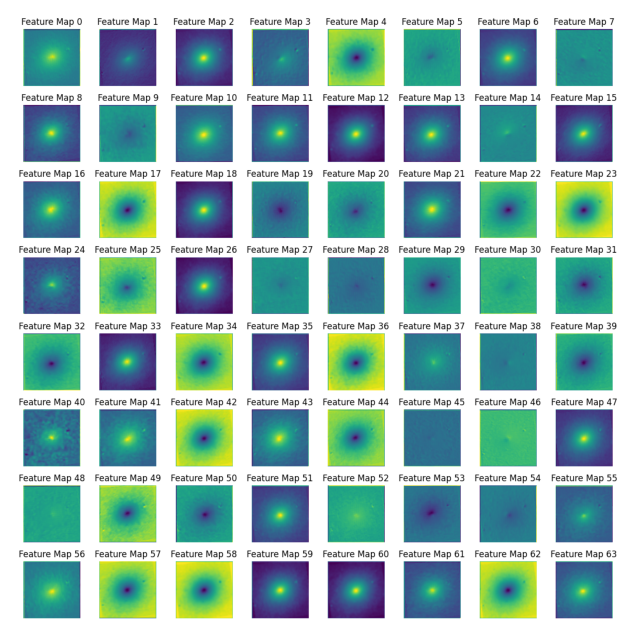

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('feature_maps_grid.png')

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

You can see the convolution layer features plotted on the image.

The final step is the weight norms. I have checked validation accuracy manually, but I have also plotted weight norms as asked.

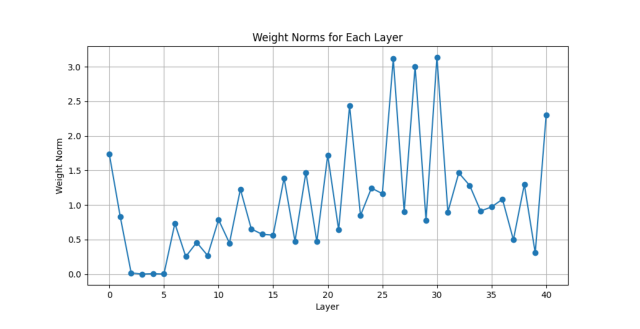

In [12]:
img = mpimg.imread('weight_norms.png')

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

It is fairly obvious what is going on here. The weight norms are fluctuating so much that it is obvious we need to train for much, much longer so that they don't fluctuate. That's why my validation accuracy is so low and the model is garbage at the moment. But testing with validation set is the gold standard.

# END

I have successfully done the first task. Though I got horrible results, I learned a lot and can confidently recreate my work and I feel I have fully understood the subject. This was my first foray into Computer Vision (I have significany experience in time-series analysis) so it is expected that I had many growing pains.

A final note on converting .pth to h5. I tried using ONXX and pytorch2keras, but neither of them worked. **This is the part of the task that I failed; I was unable to convert my model to a h5 file.**